Fitness (makespan): 2685


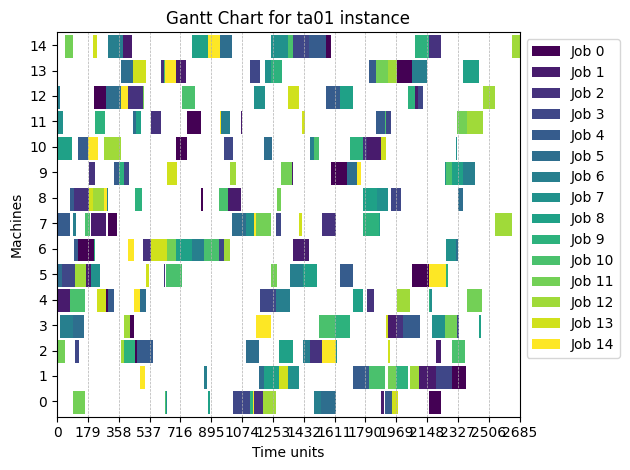

In [ ]:
from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib.visualization.gantt import plot_gantt_chart
import matplotlib.pyplot as plt
from job_shop_lib.dispatching import Dispatcher
from collections import defaultdict
import numpy as np

class Benchmark:
    def __init__(self, task_name: str):
        """コンストラクタ

        args:
            task_name (str): ベンチマーク問題の名前 (例: "ta01")
        """
        self.task_name = task_name
        self.problem = load_benchmark_instance(task_name)
        self.num_jobs = self.problem.num_jobs
        self.num_machines = self.problem.num_machines
        self.optimal_value = self.problem.metadata["optimum"]

    def __call__(self, solution: np.ndarray) -> int:
        """連続値をランダムキー符号化で離散値に変換し、スケジューリング問題のメイクスパンを計算
        
        args:
            solution (np.ndarray): 解、連続値、(num_jobs * num_machines,)

        returns:
            make_span (int): メイクスパン
        """
        def _inc(counter, key: int):
            """ジョブの順序をカウントアップするヘルパー関数"""
            counter[key] = counter.get(key, -1) + 1
            return counter[key]

        jobs = self.problem.jobs

        solution_sequence = np.argsort(np.argsort(solution)) # 連続値 → シーケンス番号(tlに）
        solution_job = solution_sequence % self.num_jobs # シーケンス番号 → ジョブ番号 (S=(tl mod n_jobs))
        cnt = defaultdict(int)
        solution_job_order = [(int(job_num), _inc(cnt, job_num)) for job_num in solution_job] # (ジョブ番号, ジョブ内の順序)

        # solution_job_orderをもとに、制約条件を満たすように配置
        dispatcher = Dispatcher(self.problem)
        for i, j in solution_job_order:
            dispatcher.dispatch(jobs[i][j], jobs[i][j].machine_id)

        # メイクスパンを計算
        make_span = dispatcher.schedule.makespan()

        return make_span
    
    def __str__(self):
        return f"Benchmark(task_name={self.task_name}, num_jobs={self.num_jobs}, num_machines={self.num_machines})"
    
    def gantt_chart(self, solution: np.ndarray):
        """ガントチャートを表示
        
        args:
            solution (np.ndarray): 解、連続値、(num_jobs * num_machines,)
        """
        def _inc(counter, key):
            counter[key] = counter.get(key, -1) + 1
            return counter[key]
        
        jobs = self.problem.jobs
        
        solution_sequence = np.argsort(np.argsort(solution))
        solution_job = solution_sequence % self.num_jobs
        cnt = defaultdict(int)
        solution_job_order = [(int(job_num), _inc(cnt, job_num)) for job_num in solution_job]
        dispatcher = Dispatcher(self.problem)
        for i, j in solution_job_order:
            dispatcher.dispatch(jobs[i][j], jobs[i][j].machine_id)
        
        # ガントチャートを表示
        plot_gantt_chart(dispatcher.schedule)
        plt.tight_layout()
        plt.show()

# 使用例
func = Benchmark("ta01")
solution = np.random.uniform(-5, 5, func.num_jobs * func.num_machines)
fitness = func(solution)
print("Fitness (makespan):", fitness)
func.gantt_chart(solution)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Tuple, Callable

class TSA:
    def __init__(self, func: Callable, n_trees: int, dim: int, lower_bound: float, upper_bound: float, st: float, optimal_value: float = 0.0):
        """ コンストラクタ
        
        args:
            func (Callable): 最適化関数
            n_trees (int): 木の数
            dim (int): 次元数
            lower_bound (float): 探索空間の下限
            upper_bound (float): 探索空間の上限
            st (float): 探索傾向
        """
        self.func = func
        self.N = n_trees
        self.D = dim
        self.lb = lower_bound
        self.ub = upper_bound
        self.ST = st
        self.MAX_FEs = dim * 1e3 # 最大評価回数
        self.MES  =1e-8 # 収束判定閾値
        self.optimal_value = optimal_value

        self.trees = self.initialize_trees() # 木の位置
        self.fitness = np.array([self.func(tree) for tree in self.trees]) # 各木の評価値

    def initialize_trees(self) -> np.ndarray:
        """ 木の初期化
        
        return:
            trees (np.ndarray): 初期化された木の位置
        """
        trees = self.lb + np.random.uniform(0, 1, (self.N, self.D)) * (self.ub - self.lb)
        return trees
    
    def optimize(self) -> Tuple[np.ndarray, float]:
        """ 最適化の実行
        
        return:
            tuple[np.ndarray, float]: 最適解とその評価値
        """

        ### setep.1 初期化
        self.fes_counter = 0 # 評価回数カウンタ
        self.iter_counter = 0 # イテレーションカウンタ
        self.trees = self.initialize_trees()
        self.fitness = np.array([self.func(tree) for tree in self.trees])
        self.best_tree = self.trees[np.argmin(self.fitness)] # 最良木
        self.best_fitness = np.min(self.fitness) # 最良評価値

        self.history_best_fitness = [self.best_fitness] # 最良評価値の履歴
        self.history_best_tree = [self.best_tree] # 最良木の履歴

        while (True):
            ### 種子の生成
            self.seeds, self.fitness_seeds = self.generate_seeds()

            ### 木の更新
            self.update_trees()

            ### 収束判定
            if (self.optimal_value is not None) and (abs(self.best_fitness - self.optimal_value) < self.MES):
                print(f"Iteration: {self.iter_counter}, Find the optimal solution!")
                break
            elif self.fes_counter >= self.MAX_FEs:
                print(f"Iteration: {self.iter_counter}, Reached the maximum number of function evaluations.")
                break

            self.iter_counter += 1
            if self.iter_counter % 10 == 0:
                print(f"Iteration: {self.iter_counter}, Best fitness: {self.best_fitness}")

        return (self.best_tree, self.best_fitness)

    def generate_seeds(self) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """ 種子の生成
        return:
            tuple[List[np.ndarray], List[np.ndarray]]: 生成された種子とその評価値
        """
        seeds = []
        fitness_seeds = []

        for i in range(self.N):
            num_seeds = int(self.N * np.random.uniform(0.1, 0.25) + 0.5) # 各木が生成する種子の数
            seeds_i = []
            fitness_seeds_i = []
            for _ in range(num_seeds):
                if np.random.rand() < self.ST:
                    # 最良木に向かう探索
                    seed = self.trees[i] + np.random.uniform(-1.0, 1.0, self.D) * (self.best_tree - self.trees[i])
                    seed = np.clip(seed, self.lb, self.ub)
                    seeds_i.append(seed)
                    fitness_seeds_i.append(self.func(seed))
                else:
                    # ランダム な木との探索
                    j = np.random.randint(0, self.N)
                    seed = self.trees[i] + np.random.uniform(-1.0, 1.0, self.D) * (self.trees[j] - self.trees[i])
                    seed = np.clip(seed, self.lb, self.ub)
                    seeds_i.append(seed)
                    fitness_seeds_i.append(self.func(seed))
                self.fes_counter += 1
            seeds.append(seeds_i)
            fitness_seeds.append(fitness_seeds_i)
        return (seeds, fitness_seeds)

    def update_trees(self) -> None:
        """ 木の更新
        """
        for i in range(self.N):
            # 種子の中で最良のものを選択
            best_seed_idx = np.argmin(self.fitness_seeds[i])
            best_seed = self.seeds[i][best_seed_idx]
            best_seed_fitness = self.fitness_seeds[i][best_seed_idx]

            # 木と種子の比較
            if best_seed_fitness < self.fitness[i]:
                self.trees[i] = best_seed
                self.fitness[i] = best_seed_fitness

                # 全体の最良木の更新
                if best_seed_fitness < self.best_fitness:
                    self.best_tree = best_seed
                    self.best_fitness = best_seed_fitness

        # 履歴の更新
        self.history_best_fitness.append(self.best_fitness)
        self.history_best_tree.append(self.best_tree)

    def plot_history_2Dheatmap(self) -> None:
        """ 最良評価値の履歴を2Dヒートマップで表示（2次元問題専用）
        """
        if self.D != 2:
            raise ValueError("This method is only available for 2D problems.")

        x = np.linspace(self.lb+10, self.ub+10, 100)
        y = np.linspace(self.lb+10, self.ub+10, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[self.func(np.array([x, y])) for x in x] for y in y])
        plt.figure(figsize=(10, 8))
        plt.contourf(X, Y, Z, levels=50, cmap='viridis')
        plt.colorbar(label='Function Value')
        best_trees = np.array(self.history_best_tree)
        plt.plot(best_trees[:, 0], best_trees[:, 1], marker='o', color='red', markersize=5, label='Best Tree Path')
        plt.title('TSA Optimization Path')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.legend()
        plt.show()

    def plot_history(self) -> None:
        """ 最良評価値の履歴を表示
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.history_best_fitness, marker='o')
        plt.yscale('log')
        plt.title('TSA Best Fitness History')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness (log scale)')
        plt.grid()
        plt.show()

In [23]:
# func (Callable): 最適化関数
# n_trees (int): 木の数
# dim (int): 次元数
# loweer_bound (float): 探索空間の下限
# upper_bound (float): 探索空間の上限
# st (float): 探索傾向

func = Benchmark("ta01")
args = {
    "func": func,
    "n_trees": 40,
    "dim": func.num_jobs * func.num_machines,
    "lower_bound": -5,
    "upper_bound": 5,
    "st": 0.2,
    "optimal_value": func.optimal_value
}

tsa = TSA(**args)
best_solution, best_fitness = tsa.optimize()
print("Best solution:", best_solution)
print("Best fitness:", best_fitness)

Iteration: 10, Best fitness: 1925
Iteration: 20, Best fitness: 1893
Iteration: 30, Best fitness: 1814
Iteration: 40, Best fitness: 1814
Iteration: 50, Best fitness: 1803
Iteration: 60, Best fitness: 1803
Iteration: 70, Best fitness: 1803
Iteration: 80, Best fitness: 1803
Iteration: 90, Best fitness: 1803
Iteration: 100, Best fitness: 1803
Iteration: 110, Best fitness: 1803
Iteration: 120, Best fitness: 1803
Iteration: 130, Best fitness: 1773
Iteration: 140, Best fitness: 1773
Iteration: 150, Best fitness: 1773
Iteration: 160, Best fitness: 1773
Iteration: 170, Best fitness: 1773
Iteration: 180, Best fitness: 1708
Iteration: 190, Best fitness: 1708
Iteration: 200, Best fitness: 1708
Iteration: 210, Best fitness: 1708
Iteration: 220, Best fitness: 1708
Iteration: 230, Best fitness: 1708
Iteration: 240, Best fitness: 1708
Iteration: 250, Best fitness: 1708
Iteration: 260, Best fitness: 1708
Iteration: 270, Best fitness: 1708
Iteration: 280, Best fitness: 1708
Iteration: 290, Best fitness: